In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt

c:\Users\zzoon\anaconda3\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 퀘스트

1. transformer에서 변경이 필요한 부분  
 i. 인코더 부분 제거  
 ii. 포지셔녈 임베딩을 학습가능한 벡터로 구성   
 iii. 손실함수가 변경  
 iv. 디코더에서 인코더-디코더 부분 제거  
 v. 디코더 블록이 끝난 후 embedding_matrix와 곱하고 softmax를 거쳐 출력  
2. 모델에 맞게 전처리  
 i. 레이블이 필요 없기 때문에 a,q를 합쳐서 사용  
 ii. dataset을 만들 때 encoder_input이 불필요  
3. 모델의 입력 블록을 GPT논문에 기반하여 수정  
 나름 바꿨다고 생각했는데 자신은 없습니다.  
4. GPT모델이 정상적으로 구성  
 나름 바꿨다고 생각했는데 자신은 없습니다 2.  
5. 정상적 출력   
 반복적인 단어의 뭉치로 나왔음

## 0. gpt 모듈

포지셔널 인코딩

In [3]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

    def __init__(self, max_position, d_model):
        super(PositionalEncoding, self).__init__()   # 부모 클래스 상속 초기화, 필수는 아님 
        self.pos_encoding = self.add_weight(
            "pos_encoding",
            shape=[1, max_position, d_model],
            initializer=tf.keras.initializers.RandomNormal(),
            trainable=True)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

스케일드 닷 프로덕트

In [4]:
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    # tf.shape(key)[-1] = 워드벡터의 크기 
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    # 마스크의 1이면 큰값을 빼는 거니까 softmax를 지나면 0에 수렴  
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output


멀티헤드 어텐션

In [5]:
class MultiHeadAttention(tf.keras.layers.Layer):

    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model
        
        # 워드벡터가 헤드수로 나머지 없이 나누어 져야함
        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        # input.shape : [batch_size, seq_len, d_model(self.num_head*self.depth)]
            # seq_len : 문장길이
            # d_model : 임베딩 차원 
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        # [batch_size, self.num_head, seq_len, self.depth)]
        # transpose를 통해 num_heads를 앞으로 불러와 병렬연산 효율성(gpu활용성)을 높임 
            # 일반적으로 뒷 차원의 크기가 클 수록 효율적
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query,batch_size)
        key = self.split_heads(key,batch_size)
        value = self.split_heads(value,batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention = scaled_dot_product_attention(query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

    def get_config(self):
        return {
            'num_heads': self.num_heads,
            'd_model': self.d_model,
            'depth': self.depth,
            'query_dense': self.query_dense,
            'key_dense': self.key_dense,
            'value_dense': self.value_dense,
            'dense': self.dense,
        }

코잘 마스킹(패딩)

In [6]:
# 숫자가 0인 부분을 체크한 벡터를 리턴
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

In [7]:
# 숫자가 0인 부분도 마스킹
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    # tf.linalg.band_part: 대각요소를 가져오거나 이를 기준을 다른 것을 제거 
        # (텐서, 유지할 아래 대각요소, 유지할 위 대각요소) -1이면 전부 
        # 대각요소는 항상 유지 
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

### 디코더

In [8]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    look_ahead_mask = tf.keras.Input(
    shape=(1, None, None), name="look_ahead_mask")

    # 첫 번째 서브 레이어 : 마스크트 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
    d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.Dropout(rate=dropout)(attention1)
    attention1 = tf.keras.layers.LayerNormalization(
    epsilon=1e-6)(attention1 + inputs)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention1)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
    epsilon=1e-6)(outputs + attention1)

    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)

In [61]:
# 전체 디코더, 디코더 층 여러개
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            max_len,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    # 마스크
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')


    # 임베딩 레이어
    embedding_layer = tf.keras.layers.Embedding(vocab_size, d_model)
    embeddings = embedding_layer(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings_pos = PositionalEncoding(max_len, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings_pos)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, look_ahead_mask])
        
    @tf.function
    def get_embedding_matrix():
        return embedding_layer.weights[0] * tf.math.sqrt(tf.cast(d_model, tf.float32))
    embedding_matrix = get_embedding_matrix()

    outputs = tf.matmul(outputs, embedding_matrix, transpose_b=True)
    outputs = tf.keras.layers.Activation('softmax')(outputs)


    return tf.keras.Model(
        inputs=[inputs, look_ahead_mask],
        outputs=outputs,
        name=name)


## 1. 데이터 불러오기

**[송영숙님이 공개한 챗봇 데이터를 사용](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)**  

1. 문장에서 단어와 구두점 사이에 공백을 추가한다.
2. ! ? , . 이 4개의 구두점을 제외하고 다른 특수문자는 모두 제거한다.
3. 노드와는 다르게 숫자를 지우지 않고 가-힣를 사용해서 한글을 유지한다.

* 레이블이 필요없이 비지도학습이니까 q,a구분없이 합쳐서 사용, 다만 a에 중복이 있어서 제거하고 사용

In [10]:
import pandas as pd
data = pd.read_csv('data/ChatbotData.csv')

In [11]:
data.head()

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [12]:
# 입출력을 합친 모든 문장을 가진 리스트를 만듦
dataset = data["A"].to_list()
dataset.extend(data["Q"].to_list()) 

In [13]:
len(dataset)

23646

In [14]:
# 중복값 확인
len(set(dataset))

19436

In [15]:
dataset = list(set(dataset))
len(dataset)

19436

In [16]:
dataset[:5]

['그동안 사랑했던 사람이니까요.',
 '기분이 묘한 하루네',
 '사람은 사람으로 잊는 거예요.',
 '아무렇지 않아 보여도 많이 힘들거예요.',
 '우정이 뭘까']

## 2. 전처리

In [17]:
# 전처리 함수
def preprocess_sentence(sentence):
    # 입력받은 sentence를 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()

    # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
    # 예를 들어서 "I am a student." => "I am a student ."와 같이
    # student와 온점 사이에 거리를 만듭니다.
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)

    # (a-z, A-Z,가-힣,0-9, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
    sentence = re.sub(r"[^a-zA-Z가-힣0-9\.\?\!,]"," ",sentence)
    sentence = sentence.strip()
    return sentence


In [18]:
def preprocess_sentences(sentences):
    return [preprocess_sentence(sentence) for sentence in sentences]

In [19]:
dataset = preprocess_sentences(dataset)

In [20]:
n = 21
print('전처리 후의 22번째 질문 샘플: {}'.format(dataset[n]))


전처리 후의 22번째 질문 샘플: 마음 단단히 잡으세요 .


## 3. Subword 인코딩

In [21]:
import tensorflow_datasets as tfds

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(dataset, target_vocab_size=2**13)

In [22]:
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2

In [23]:
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(dataset[21])))

정수 인코딩 후의 21번째 질문 샘플: [136, 3373, 4797, 1]


In [25]:
# max len길이를 보기위해
total_data_text = list(dataset)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 maxlen 설정값 이내에 포함됩니다. ')

문장길이 평균 :  14.60336488989504
문장길이 최대 :  78
문장길이 표준편차 :  6.774608097618809
pad_sequences maxlen :  28
전체 문장의 0.962646635110105%가 maxlen 설정값 이내에 포함됩니다. 


In [26]:
MAX_LENGTH = 28

In [27]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs):
    outputs = []
  
    for sentence in inputs:
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence = START_TOKEN + tokenizer.encode(sentence) + END_TOKEN

        # 최대 길이 28 이하인 경우에만 데이터셋으로 허용
        if len(sentence) <= MAX_LENGTH :
            outputs.append(sentence)    
        
    # 최대 길이 28으로 모든 데이터셋을 패딩
    outputs = tf.keras.preprocessing.sequence.pad_sequences(
        outputs, maxlen=MAX_LENGTH, padding='post')

  
    return outputs

In [28]:
dataset = tokenize_and_filter(dataset)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(dataset)))

단어장의 크기 : 9051
필터링 후의 질문 샘플 개수: 19434


In [29]:
data = dataset

In [30]:
BATCH_SIZE = 64
BUFFER_SIZE = 5000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
# dec_inputs[0]=answers[0], outputs[0]=answers[1]이되고 둘을 매칭 
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'dec_inputs': data[:, :-1]
    },
    {
        'outputs': data[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)


## 4. 모델 구성

In [31]:
def gpt(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                max_len,
                name="gpt"):
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")


  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)


  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
      max_len=max_len
  )(inputs=[dec_inputs, look_ahead_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[dec_inputs], outputs=outputs, name=name)


In [62]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수 2
D_MODEL = 64 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 2 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 64 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = gpt(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_len = MAX_LENGTH)

model.summary()

Model: "gpt"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 9051)   631488      dec_inputs[0][0]                 
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 9051)   81929652    decoder[0][0]                  

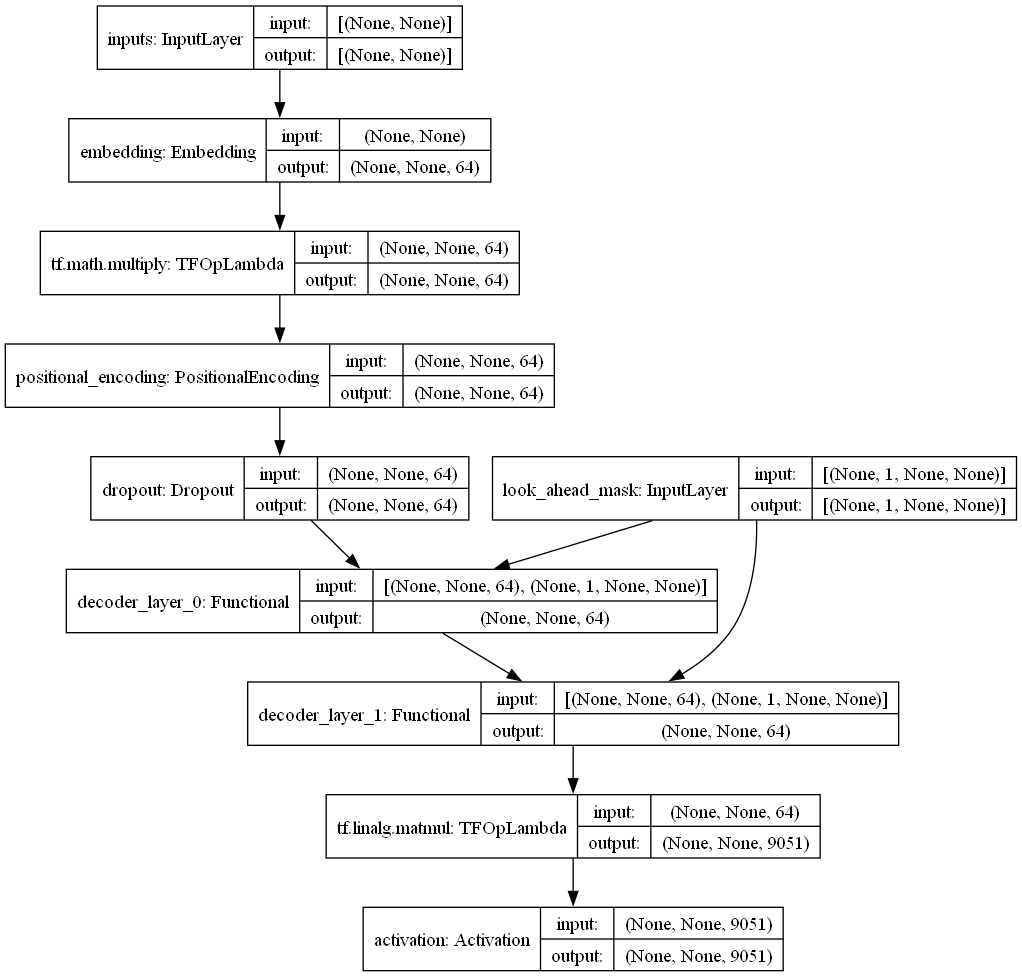

In [63]:
tf.keras.utils.plot_model(model.layers[2], show_shapes=True)

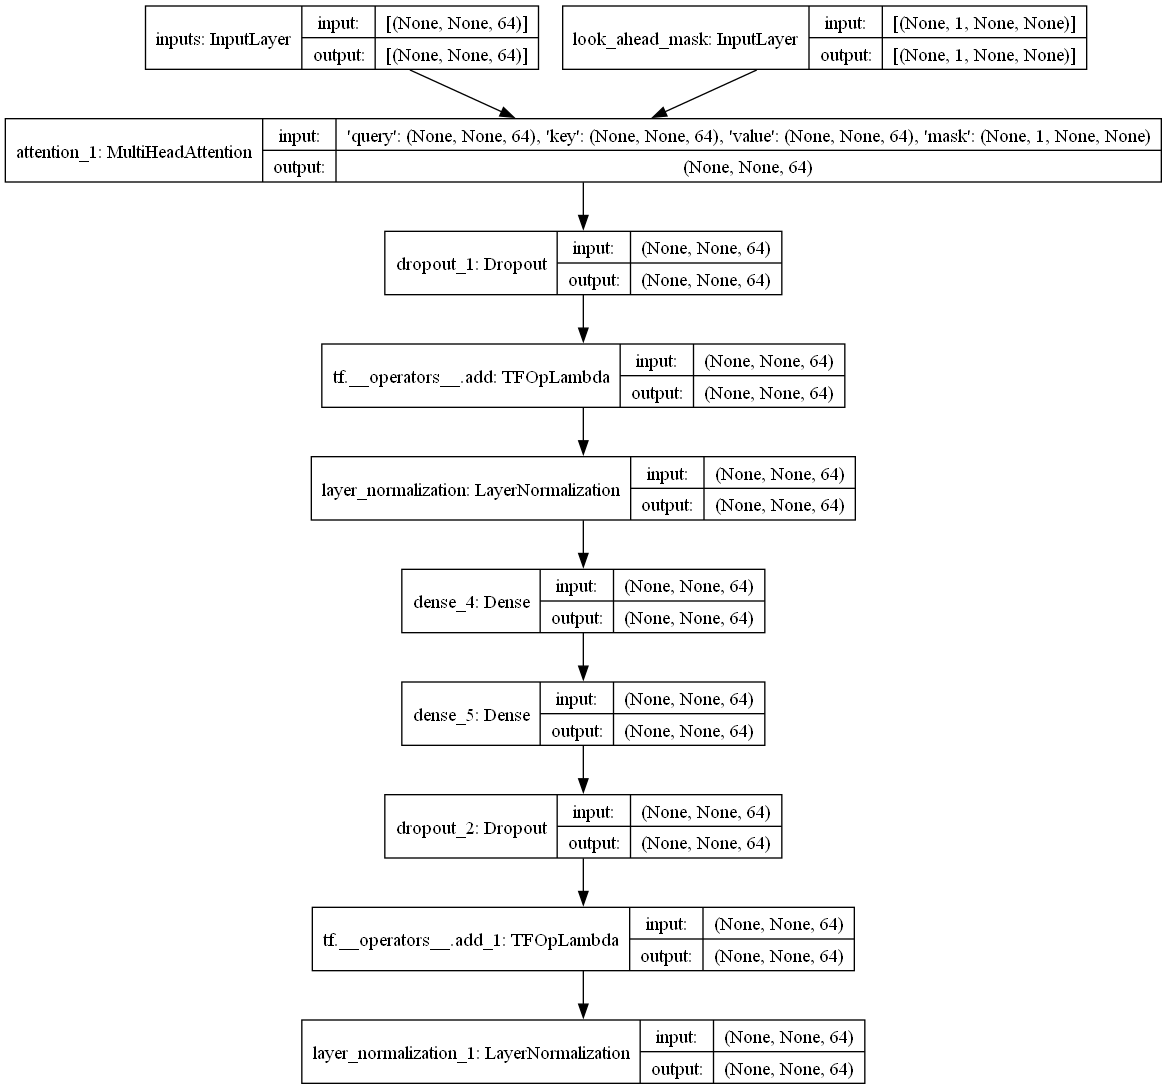

In [64]:
tf.keras.utils.plot_model(model.layers[2].layers[6], show_shapes=True)

L1 목적함수  



In [65]:
def L1_loss(y_true, y_pred):    
    # 확률 P 계산
    logits = tf.math.log(tf.clip_by_value(y_pred, 1e-10, 1.0)) 
    
    # 각 시퀀스의 손실 계산
    batch_loss = -tf.reduce_sum(logits, axis=-1)
    
    # 배치의 평균 손실 반환
    return tf.reduce_mean(batch_loss)

커스텀 학습률 스케줄링으로 동적 조정

In [66]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps**-1.5)

        # d_model이 클 수록 더 큰 학습률로 시작 
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

    def get_config(self):
            return {
                'd_model': float(self.d_model),
                'warmup_steps': self.warmup_steps
            }

Text(0.5, 0, 'Train Step')

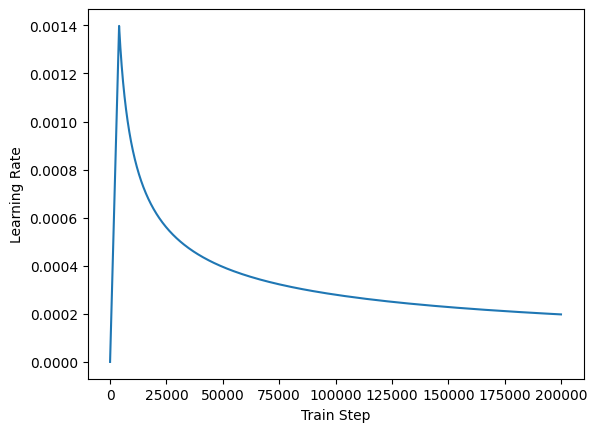

In [67]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [68]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

model.compile(optimizer=optimizer, loss=L1_loss, metrics=['accuracy'])

### 훈련

In [69]:
EPOCHS = 1

model.fit(dataset, epochs=EPOCHS, verbose=1)

304/304 [==============================] - 607s 2s/step - loss: 63274.0859 - accuracy: 3.6210e-05


In [97]:
EPOCHS = 10

model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/10
304/304 [==============================] - 553s 2s/step - loss: 23943.1738 - accuracy: 9.5289e-06
Epoch 2/10
304/304 [==============================] - 579s 2s/step - loss: 13403.6797 - accuracy: 5.7174e-06
Epoch 3/10
304/304 [==============================] - 633s 2s/step - loss: 6062.2280 - accuracy: 5.7174e-06
Epoch 4/10
304/304 [==============================] - 651s 2s/step - loss: 1034.0082 - accuracy: 1.1435e-05
Epoch 5/10
304/304 [==============================] - 630s 2s/step - loss: 47.2062 - accuracy: 2.0964e-05
Epoch 6/10
304/304 [==============================] - 621s 2s/step - loss: 46.0518 - accuracy: 1.7152e-05
Epoch 7/10
  5/304 [..............................] - ETA: 10:37 - loss: 46.0518 - accuracy: 0.0000e+00

## GPT 테스트


In [76]:
def decoder_inference(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model(inputs=[sentence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [77]:
def sentence_generation(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
  
    return predicted_sentence


In [86]:
# epoch 1에서 테스트
sentence_generation('안녕하세요')

입력 : 안녕하세요
출력 : 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 


'변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 변하는 '

#### L1로스를 찾아보다가 일반적으로 crossentropy를 사용한다길래 사용해봄

뭔가 loss랑 acc는 좋은데 결과 자체는 나오지 않았음

In [87]:
model2 = gpt(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT,
    max_len = MAX_LENGTH)

model2.summary()

Model: "gpt"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
look_ahead_mask (Lambda)        (None, 1, None, None 0           dec_inputs[0][0]                 
__________________________________________________________________________________________________
decoder (Functional)            (None, None, 9051)   631488      dec_inputs[0][0]                 
                                                                 look_ahead_mask[0][0]            
__________________________________________________________________________________________________
outputs (Dense)                 (None, None, 9051)   81929652    decoder[0][0]                  

In [88]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy


model2.compile(optimizer=optimizer, loss=SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

In [89]:
EPOCHS = 1

model2.fit(dataset, epochs=EPOCHS, verbose=1)

304/304 [==============================] - 543s 2s/step - loss: 8.9876 - accuracy: 0.7711


In [90]:
def decoder_inference2(sentence):
    sentence = preprocess_sentence(sentence)

    # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

    # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
    # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
    output_sequence = tf.expand_dims(START_TOKEN, 0)

    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
        predictions = model2(inputs=[sentence], training=False)
        predictions = predictions[:, -1:, :]

        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break

        # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
        # 이 output_sequence는 다시 디코더의 입력이 됩니다.
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

    return tf.squeeze(output_sequence, axis=0)

In [93]:
def sentence_generation2(sentence):
    # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
    prediction = decoder_inference2(sentence)

    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size])

    print('입력 : {}'.format(sentence))
    print('출력 : {}'.format(predicted_sentence))
  
    return predicted_sentence


In [96]:
sentence_generation2('안녕하세요')

입력 : 안녕하세요
출력 : 


''

## 결론 및 회고



논문을 보고 불필요 한것을 제거하는 것은 쉬웠는데, 새로운 것의 차원 수 맞추는 것이 매우 힘들었다. 
그리고 $softmax(hW^T_e)$에서 임베딩 벡터를 불러오는 것도 처음에 레이어를 그냥 곱하려고 해서 어려움이 있었다. 

이게 지금 제대로 만든 건지 모르겠는데, 파라미터 수가 너무나도 많아서 당황스러웠다. 
아직 파라미터 갯수에 대한 직관이 없어서 이게 맞는지 틀린지 조차 모르는 것이 당황스러웠다.  

헷갈리는 첫번째는 L1이다.
$P(u_i|u_{i−k}, . . . , u_{i−1}; Θ) $ 자체가 y_pred라는 것을 이해를 못해서 해메다가 
gpt가 모델을 통해 나온 값이니 그냥 y_pred라고 해서 도움을 좀 받았다. 
정말 오래 고민을 했었는데, 결국 gpt의 도움을 받다니 아직 모델과 친숙하지 않은 것 같다. 


두번째는 입력 데이터에 관한 부분이었다. 
이게 비지도 학습이라 `y`가 없어야 하는것 같다가도 $P(u_i|u_{i−k}, . . . , u_{i−1}; Θ) $를 
보면 이전 토큰에 대해 현재의 확률을 하니까 `x`를 $u_{i−k}, . . . , u_{i−1}$로, `y`를 $u_i$로 주어야 할거 같아서 
```python
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'dec_inputs': data[:, :-1]
    },
    {
        'outputs': data[:, 1:]
    },
))
```
이렇게 구현했고 결국 지도학습처럼 된거 같았다. 

마지막으로는 분명 디코더를 `tf.keras.utils.plot_model(model.layers[2].layers[6], show_shapes=True)` 통해 시각화했을 때, 
잔차연결 부분이 화살표가 없어서 당황스러웠다. 모델을 보면 입력을 2개로 잘 한거 같은데, 시각화가 안되니 진짜 잘한게 맞는지 의심스러웠다.  

마지막으로 이번 클라우드 환경이 이상했는지, 동일한 코드가 epoch 1회당 1시간 반이나 걸린다고 나오길래 급하게 로컬환경을 만드느라 시간이 부족해서 아쉬웠다. 
그렇게 로컬 환경을 구성하다가 알게되었는데, 데스크탑에 gpu가 있음에도 tensorflow가 인식을 못해서 이것도 나중에 해결해 보아야겠다고 생각했다. 결국 epoch 1회의 결과는 보았는데 epoch를 느려 학습하는 건 시간 내에 성공하지 못하였다. 